# Synaptic clusters (Notebook)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/docs/source/tutorials/Synaptic_clusters.ipynb)

In this tutorial, you will learn how to **visualize synapses on neuronal morphology** and perform **clustering analysis** using a custom distance metric (specifically, the `path_distance` between synaptic locations).


## Setup

In [1]:
# !pip install dendrotweaks

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [2]:
# import os
# os.kill(os.getpid(), 9)

Let's begin by importing the standard libraries and the dendrotweaks library.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
import dendrotweaks as dd
dd.__version__

'0.5.1'

In [5]:
dd.apply_dark_theme()

In [6]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

## Load morphology

In [7]:
path_to_model = os.path.join('examples', 'Poirazi_2003')
print(f'Path to model: {path_to_model}')

Path to model: examples/Poirazi_2003


In [8]:
model = dd.Model(path_to_model)

In [9]:
model.list_morphologies()

['original', 'main']

In [10]:
model.load_morphology(file_name='main')

Sorted PointTree(root=Point(idx=0), num_nodes=5077).
Extended 178 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=5255).


In [11]:
model.domains

{'axon': <Domain(axon, 2, #F0E442, 13 sections)>,
 'basal': <Domain(basal, 31, #31A354, 48 sections)>,
 'oblique': <Domain(oblique, 43, #8C564B, 72 sections)>,
 'soma': <Domain(soma, 1, #E69F00, 1 sections)>,
 'trunk': <Domain(trunk, 41, #56B4E9, 25 sections)>,
 'tuft': <Domain(tuft, 42, #A55194, 22 sections)>}

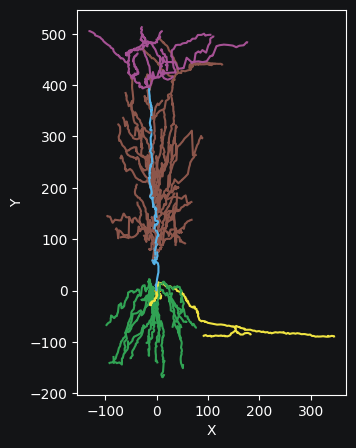

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
model.sec_tree.plot(ax, 
                    show_points=False,
                    show_lines=True,
                    annotate=False)

We also need to add the default mechanisms (including `AMPA.mod`) to be able to place synapses on our morphology.

In [13]:
model.add_default_mechanisms(recompile=False)

## Synapses

Next, we will randomly allocate 100 AMPA synapses on the sections of the tuft domain.


In [14]:
model.remove_all_stimuli()
model.remove_all_recordings()

soma = model.sec_tree[0]
model.add_recording(soma, loc=0.5)

segments = model.get_segments(['tuft'])
model.add_population(
    'excitatory',
    segments, 
    N=100, 
    syn_type='AMPA'
)

Typically, in `model.populations["excitatory"].synapses`, we store a mapping from segments to synapses that belong to those segments.

However, we can access all the synapses in this population as a list using the `flat_synapses` property of the `Population` class.

In [15]:
synapses = model.populations['excitatory'].flat_synapses

Two important attributes of a `Synapse` that we will further need are `sec` and `loc`, i.e., the section to which the synapse belongs and the relative location of the synapse along that section, respectively (0 - start, 1 - end). These two attributes unambiguously define the position of a synapse.


In [16]:
synapses[0].sec, synapses[0].loc

(NeuronSection(idx=159), 0.153)

### Distance to soma

We can use `syn.sec` and `syn.loc`, for example, to find the path distance from a synapse to the soma.


In [17]:
distances_to_soma = [
    syn.sec.path_distance(relative_position=syn.loc)
     for syn in synapses
    ]

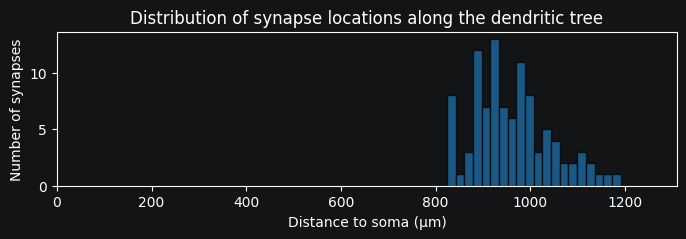

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.hist(distances_to_soma, bins=20, color='C0', edgecolor='k', alpha=0.7)
ax.set_xlabel('Distance to soma (µm)')
ax.set_ylabel('Number of synapses')
ax.set_title('Distribution of synapse locations along the dendritic tree')
ax.set_xlim(0, max(distances_to_soma) * 1.1)
plt.show()

### Synapse coordinates

Consider now that we want to find the 3D coordinates for a synapse that correspond to its more abstract coordinates defined by `sec` and `loc` attributes. We will utilize a general-purpose `get_location_coordinates` method of the `Section` class.

For example, let's calculate the `x`, `y`, `z` coordinates in the middle of a section.


In [19]:
x, y, z = model.sec_tree[50].get_location_coordinates(loc=0.5)

To get the 3D coordinates of each synapse in our previously obtained list of synapses, we will use the `syn.xyz()` method that internally relies on the `get_location_coordinates` method.


In [20]:
syn_coords = [syn.xyz() for syn in synapses]

We can now use these coordinates to visualize the synapses on the section tree plot.

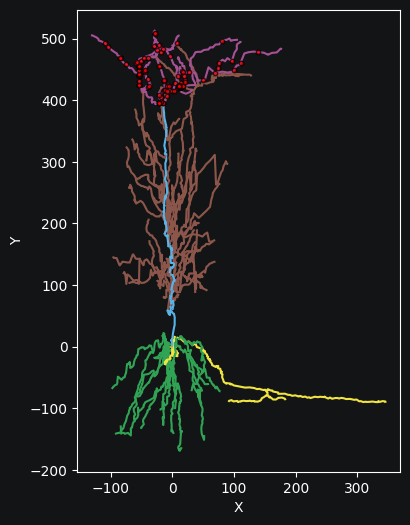

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
model.sec_tree.plot(ax, show_points=False, show_lines=True, annotate=False)
xs = [coord[0] for coord in syn_coords]
ys = [coord[1] for coord in syn_coords]
ax.scatter(xs, ys, color='r', edgecolor='k', alpha=0.7, label='Synapse locations', s=10)

## Clustering analysis

Next, we will see how to use an external clustering algorithm, such as [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) (Density-Based Spatial Clustering for Applications with Noise), to split synapses into clusters.


A clustering algorithm essentially relies on calculating distances between data points. Consider the following toy example with some data points on a 2D plane. A distance used for assigning cluster labels here is simply the Euclidean distance between two points.
However, in our case, these distances are not Euclidean distances on a 2D plane but path distances between two points on the dendritic tree. We will precompute these distances and then pass them to the DBSCAN algorithm.


In [22]:
#!pip install scikit-learn

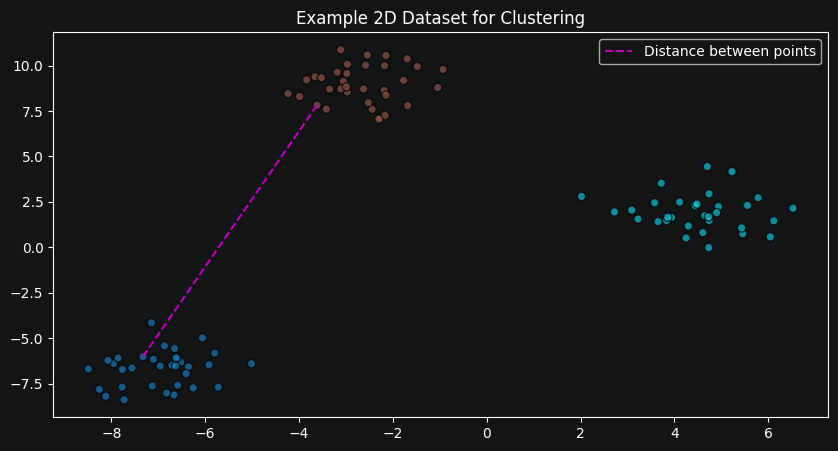

In [23]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
X, _ = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
point1 = X[22]
point2 = X[13]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', edgecolor='k', alpha=0.7)
ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'm--', label='Distance between points')
ax.legend()
ax.set_title('Example 2D Dataset for Clustering')
plt.show()

However, in our case, these distances are not Euclidean distances on a 2D plane but path distances between two points on the dendritic tree. We will precompute these distances and then pass them to the DBSCAN algorithm.

In [24]:
from dendrotweaks.analysis import calculate_pairwise_synaptic_distances

In [25]:
pairwise_distances_matrix = calculate_pairwise_synaptic_distances(
    model.populations['excitatory'].flat_synapses
)

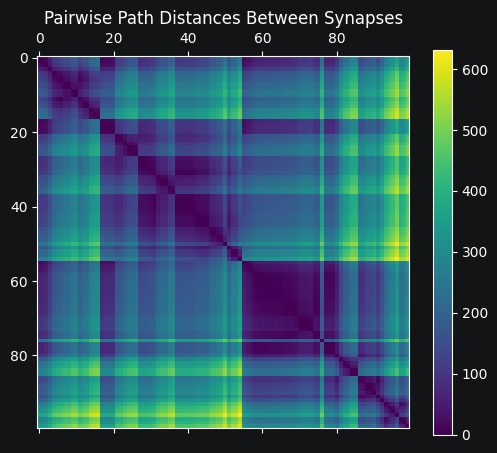

In [26]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.matshow(pairwise_distances_matrix, cmap='viridis')
fig.colorbar(cax)
ax.set_title('Pairwise Path Distances Between Synapses')
plt.show()

In [27]:
# Validate properties of the distance matrix
print(f"Matrix symmetric? {np.allclose(pairwise_distances_matrix, pairwise_distances_matrix.T)}")
print(f"Diagonal all zeros? {np.allclose(np.diag(pairwise_distances_matrix), 0)}")

Matrix symmetric? True
Diagonal all zeros? True


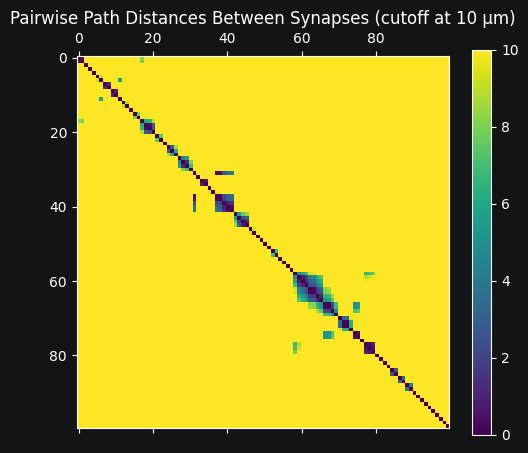

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cutoff = 10
distances_cutoff = np.where(pairwise_distances_matrix > cutoff, cutoff, pairwise_distances_matrix)
cax = ax.matshow(distances_cutoff, cmap='viridis', vmax=cutoff)
fig.colorbar(cax)
ax.set_title(f'Pairwise Path Distances Between Synapses (cutoff at {cutoff} µm)')
plt.show()

Now we are ready to run the DBSCAN algorithm

In [29]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=10, min_samples=3, metric='precomputed')
labels = db.fit_predict(pairwise_distances_matrix)

In [30]:
def get_synapses_in_cluster(cluster_label, synapses, labels):
    return [syn for syn, label in zip(synapses, labels) if label == cluster_label]

In [31]:
get_synapses_in_cluster(0, synapses, labels)

[<Synapse(NeuronSection(idx=159)(0.153))>,
 <Synapse(NeuronSection(idx=159)(0.270))>,
 <Synapse(NeuronSection(idx=163)(0.080))>,
 <Synapse(NeuronSection(idx=163)(0.168))>,
 <Synapse(NeuronSection(idx=163)(0.174))>,
 <Synapse(NeuronSection(idx=163)(0.208))>]

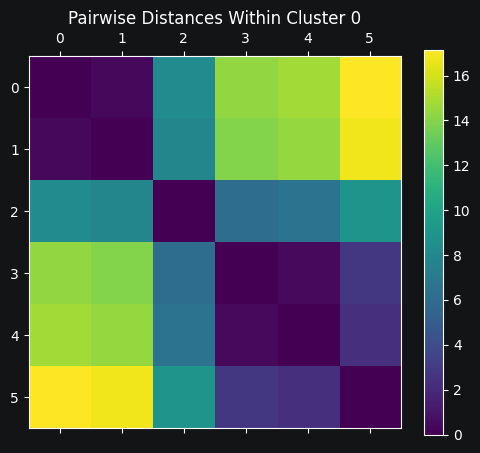

In [32]:
cluster = calculate_pairwise_synaptic_distances(get_synapses_in_cluster(0, synapses, labels))
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.matshow(cluster, cmap='viridis')
fig.colorbar(cax)
ax.set_title('Pairwise Distances Within Cluster 0')
plt.show()

We can visualize the number of synapses in each cluster. Note that the -1 cluster (the outliers) is not shown

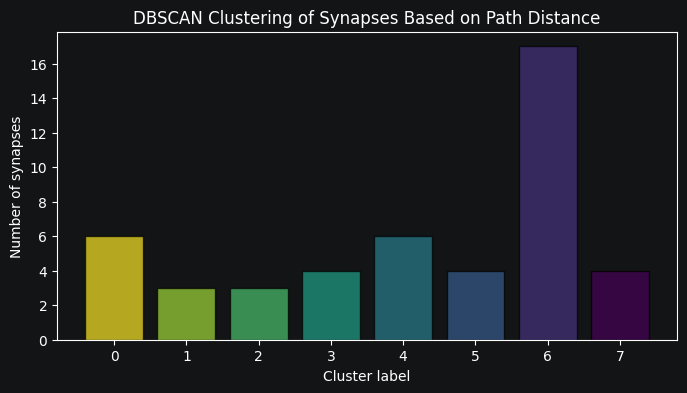

In [33]:
# Plot histogram of labels
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
filtered_labels = labels[labels != -1]  # Exclude noise points
unique_labels, counts = np.unique(filtered_labels, return_counts=True)

colors = [plt.cm.viridis_r(label / max(unique_labels)) for label in unique_labels]
ax.bar(unique_labels, counts, color=colors, edgecolor='k', alpha=0.7)
ax.set_xlabel('Cluster label')
ax.set_ylabel('Number of synapses')
ax.set_title('DBSCAN Clustering of Synapses Based on Path Distance')
plt.show()

We can finally visualize the synapses on the tuft dendrites and color them by cluster.

(350.0, 550.0)

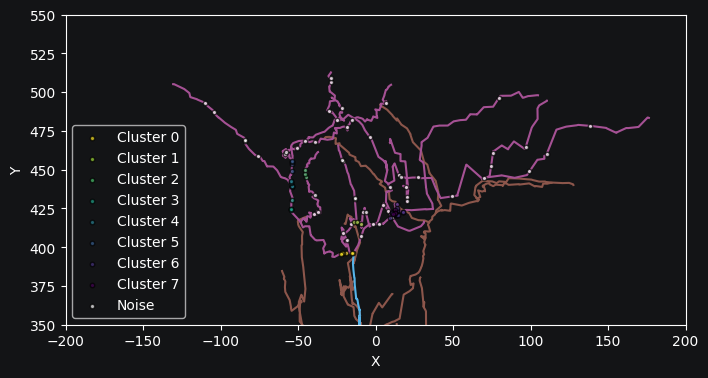

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

model.sec_tree.plot(ax, show_points=False, show_lines=True, annotate=False)

xs = [coord[0] for coord in syn_coords]
ys = [coord[1] for coord in syn_coords]

for label in set(labels):
    if label == -1:
        ax.scatter([xs[i] for i in range(len(labels)) if labels[i] == label],
                   [ys[i] for i in range(len(labels)) if labels[i] == label],
                   color='w', edgecolor='k', alpha=0.7, label='Noise', s=10, zorder=0)
    else:
        color = plt.cm.viridis_r(label / max(labels))
        
        label_name = f'Cluster {label}'
        ax.scatter([xs[i] for i in range(len(labels)) if labels[i] == label],
                   [ys[i] for i in range(len(labels)) if labels[i] == label],
                   color=color, edgecolor='k', alpha=0.7, label=label_name, s=10)

ax.legend()
ax.set_xlim(-200, 200)
ax.set_ylim(350, 550)

In [35]:
def plot_scalebar(ax, length=10, location=(0.1, 0.1), color='C1', lw=2, fontsize=8):
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_range = xlim[1] - xlim[0]
        y_range = ylim[1] - ylim[0]
        scalebar_length_x = length * (x_range / max(x_range, y_range))
        scalebar_length_y = length * (y_range / max(x_range, y_range))
        ax.plot([xlim[0] + location[0] * x_range, xlim[0] + location[0] * x_range + scalebar_length_x],
                [ylim[0] + location[1] * y_range, ylim[0] + location[1] * y_range],
                color=color, lw=lw)
        ax.text(xlim[0] + location[0] * x_range + scalebar_length_x / 2,
                ylim[0] + location[1] * y_range - 0.02 * y_range,
                f'{length} µm', ha='center', va='top', fontsize=fontsize, color=color)


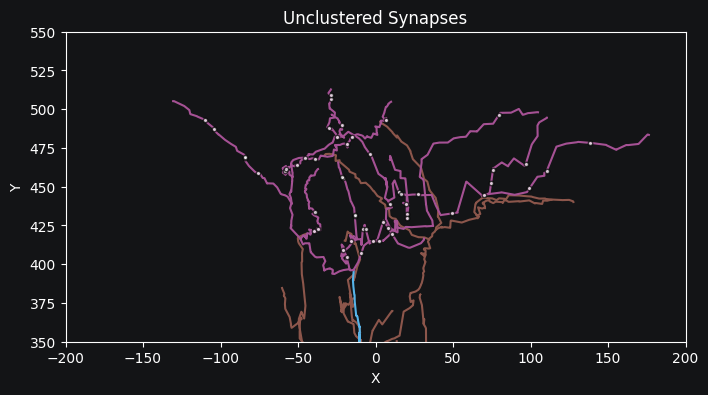

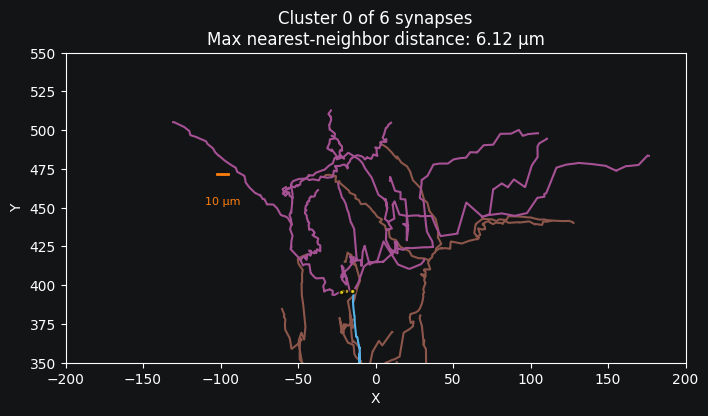

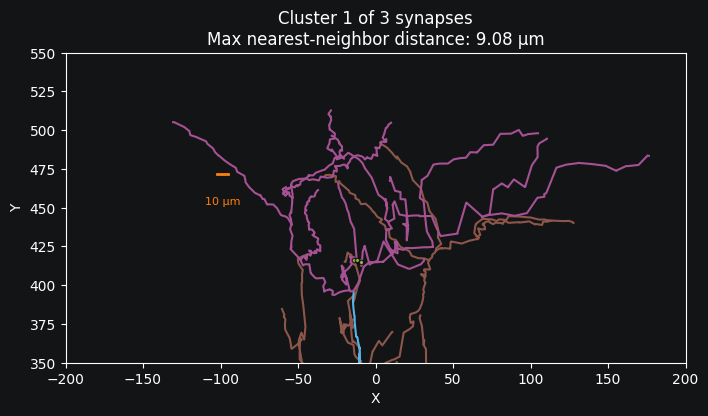

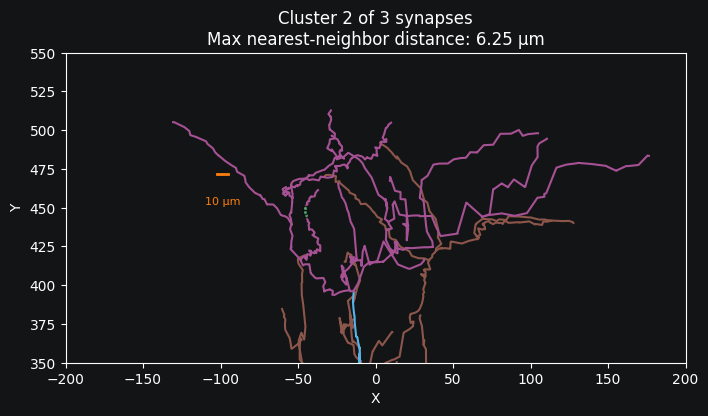

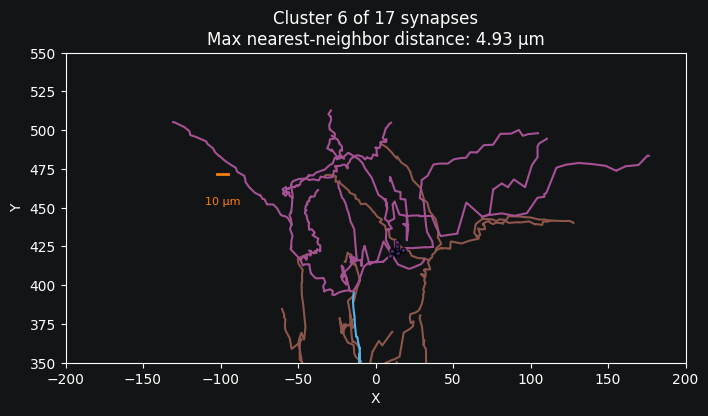

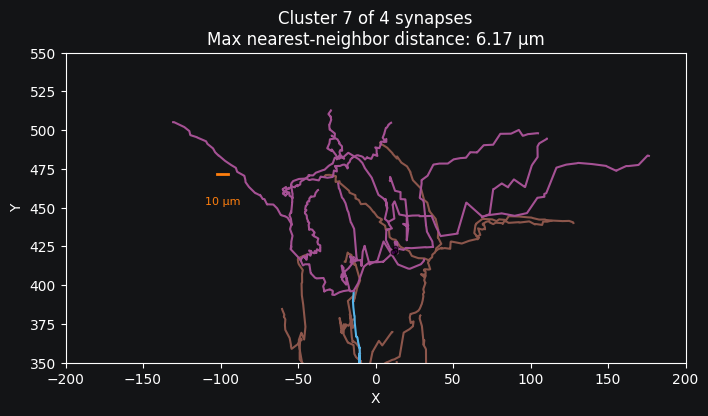

In [40]:
noise_indices = [i for i in range(len(labels)) if labels[i] == -1]
if noise_indices:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.sec_tree.plot(ax, show_points=False, show_lines=True, annotate=False)
    ax.scatter([xs[i] for i in noise_indices],
               [ys[i] for i in noise_indices],
               color='w', edgecolor='k', alpha=0.7, label='Unclustered', s=10, zorder=0)
    ax.set_xlim(-200, 200)
    ax.set_ylim(350, 550)
    ax.set_title('Unclustered Synapses')



unique_clusters = [label for label in set(labels) if label != -1]
selected_clusters = np.random.choice(unique_clusters, size=min(5, len(unique_clusters)), replace=False)

for label in sorted(selected_clusters):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    model.sec_tree.plot(ax, show_points=False, show_lines=True, annotate=False)
    plot_scalebar(ax, length=10, location=(0.1, 0.9), color='C1', lw=2, fontsize=8)
    
    cluster_indices = [i for i in range(len(labels)) if labels[i] == label]
    cluster_distances = pairwise_distances_matrix[np.ix_(cluster_indices, cluster_indices)]
    np.fill_diagonal(cluster_distances, np.inf)  # Ignore self-distances
    min_distances_to_neighbor = np.min(cluster_distances, axis=1)
    max_nearest_neighbor_dist = np.max(min_distances_to_neighbor)
    
    color = plt.cm.viridis_r(label / max(labels))
    
    ax.scatter([xs[i] for i in cluster_indices],
               [ys[i] for i in cluster_indices],
               color=color, edgecolor='k', alpha=0.7, s=10)
    ax.set_xlim(-200, 200)
    ax.set_ylim(350, 550)
    ax.set_title(f'Cluster {label} of {len(cluster_indices)} synapses\n'
                 f'Max nearest-neighbor distance: {max_nearest_neighbor_dist:.2f} µm')
    